# Random Forest

In [8]:
import pandas as pd
import numpy as np
import joblib
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier

In [2]:
import sys
import os

sys.path.append(os.path.abspath(".."))

from utils import load_and_prepare_data, evaluate_metrics, plot_roc_curve, optimize_threshold

In [3]:
df = pd.read_parquet("../diabetes_dataset_prepared.parquet")
X_train, X_test, y_train, y_test = load_and_prepare_data(df)

We will first fit a random forest model using the default hyperparameters, and only setting the random state and n_jobs. This will give us a nice baseline.

In [5]:
rf_untuned = RandomForestClassifier(random_state=2025, n_jobs=-1)

rf_untuned.fit(X_train, y_train)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [6]:
y_train_pred = rf_untuned.predict(X_train)
y_test_pred = rf_untuned.predict(X_test)

Training Set Metrics:


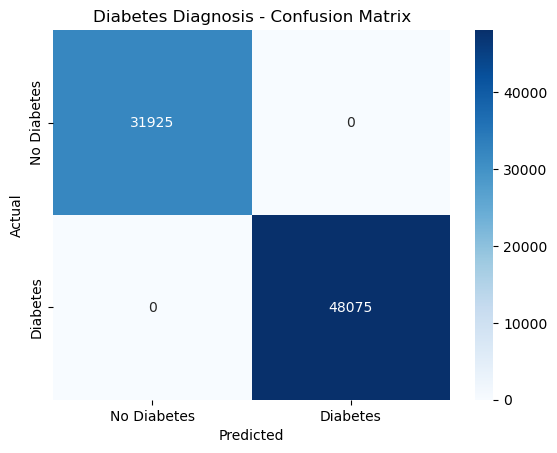

Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0


Test Set Metrics:


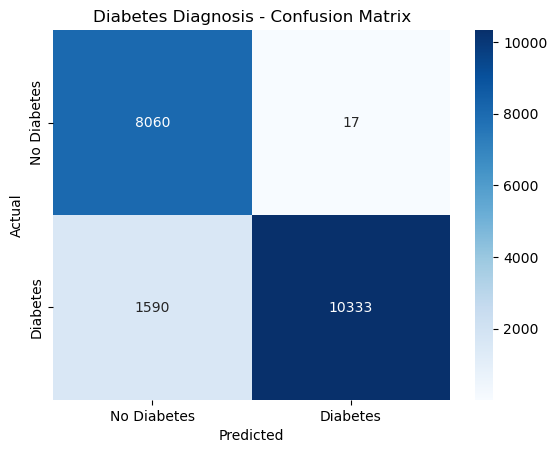

Accuracy: 0.91965
Precision: 0.9983574879227053
Recall: 0.8666443009309738
F1 Score: 0.9278498630629013


In [7]:
evaluate_metrics(y_train, y_train_pred, "Training Set Metrics:")

print("\n" + "="*75 + "\n")

evaluate_metrics(y_test, y_test_pred, "Test Set Metrics:")

While being obviously overfit, this random forest model scores perfectly on the training set, and still reaches an f1 score of roughly 0.928 on the test set, which is very close to the best one so far.

Now, we will look for the best hyperparameters. We will begin with slightly smaller values of n_iter and cv, until we get closer to the best hyperparameters.

In [9]:
rf = RandomForestClassifier(random_state=2025)

parameters = {
    'n_estimators': np.arange(200, 1001, 200),
    'max_features': ['sqrt', None],
    'bootstrap': [True, False],
    'max_samples': [None, 0.5, 0.75, 0.9],
    'max_depth': [None, 10, 20, 30],
    'min_samples_leaf': [1, 2, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
}

rf_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=parameters,
    n_iter=70,
    scoring='f1',
    cv=3,
    random_state=2025,
    n_jobs=-1,
    verbose=1
)

rf_search.fit(X_train, y_train)


Fitting 3 folds for each of 70 candidates, totalling 210 fits


c:\Users\Sebastijan\anaconda3\envs\diabetes-insight\Lib\site-packages\sklearn\model_selection\_validation.py:516: FitFailedWarning: 
63 fits failed out of a total of 210.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
63 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Sebastijan\anaconda3\envs\diabetes-insight\Lib\site-packages\sklearn\model_selection\_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Sebastijan\anaconda3\envs\diabetes-insight\Lib\site-packages\sklearn\base.py", line 1365, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Sebastijan\anaconda3

,estimator,RandomForestC...om_state=2025)
,param_distributions,"{'bootstrap': [True, False], 'max_depth': [None, 10, ...], 'max_features': ['sqrt', None], 'max_samples': [None, 0.5, ...], ...}"
,n_iter,70
,scoring,'f1'
,n_jobs,-1
,refit,True
,cv,3
,verbose,1
,pre_dispatch,'2*n_jobs'
,random_state,2025
,error_score,nan


In [10]:
n_estimators = rf_search.best_params_['n_estimators']
max_features = rf_search.best_params_['max_features']
bootstrap = rf_search.best_params_['bootstrap']
max_samples = rf_search.best_params_['max_samples']
max_depth = rf_search.best_params_['max_depth']
min_samples_leaf = rf_search.best_params_['min_samples_leaf']
min_samples_split = rf_search.best_params_['min_samples_split']

rf_search.best_params_

{'n_estimators': np.int64(200),
 'min_samples_split': 10,
 'min_samples_leaf': 10,
 'max_samples': None,
 'max_features': None,
 'max_depth': None,
 'bootstrap': True}

In [11]:
rf1 = RandomForestClassifier(
    n_estimators=n_estimators,
    max_features=max_features,
    bootstrap=bootstrap,
    max_samples=max_samples,
    max_depth=max_depth,
    min_samples_leaf=min_samples_leaf,
    min_samples_split=min_samples_split,
    random_state=2025,
    n_jobs=-1
)

rf1.fit(X_train, y_train)

,n_estimators,np.int64(200)
,criterion,'gini'
,max_depth,None
,min_samples_split,10
,min_samples_leaf,10
,min_weight_fraction_leaf,0.0
,max_features,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [12]:
y_train_pred = rf1.predict(X_train)
y_test_pred = rf1.predict(X_test)

Training Set Metrics:


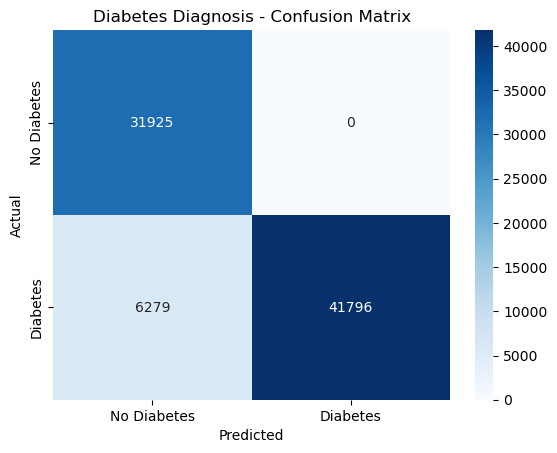

Accuracy: 0.9215125
Precision: 1.0
Recall: 0.8693915756630265
F1 Score: 0.9301331909069667


Test Set Metrics:


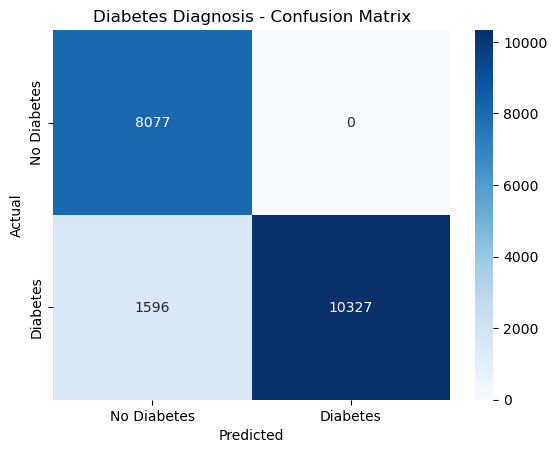

Accuracy: 0.9202
Precision: 1.0
Recall: 0.866141071877883
F1 Score: 0.9282696629213483


In [13]:
evaluate_metrics(y_train, y_train_pred, "Training Set Metrics:")

print("\n" + "="*75 + "\n")

evaluate_metrics(y_test, y_test_pred, "Test Set Metrics:")

The f1 score on the test set here is exactly the same as the one we got with the decision tree model. We will now continue searching for the best hyperparameters.

In [14]:
rf = RandomForestClassifier(random_state=2025)

parameters = {
    'n_estimators': [100, 150, 200, 250, 300],
    'max_features': ['log2', None],
    'bootstrap': [True],
    'max_samples': [None, 0.1, 0.2, 0.3],
    'max_depth': [None, 2, 5, 10, 15],
    'min_samples_leaf': [8, 10, 12, 15],
    'min_samples_split': [8, 10, 12, 15],
}

rf_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=parameters,
    n_iter=70,
    scoring='f1',
    cv=3,
    random_state=2025,
    n_jobs=-1,
    verbose=1
)

rf_search.fit(X_train, y_train)

n_estimators = rf_search.best_params_['n_estimators']
max_features = rf_search.best_params_['max_features']
bootstrap = rf_search.best_params_['bootstrap']
max_samples = rf_search.best_params_['max_samples']
max_depth = rf_search.best_params_['max_depth']
min_samples_leaf = rf_search.best_params_['min_samples_leaf']
min_samples_split = rf_search.best_params_['min_samples_split']

rf_search.best_params_

Fitting 3 folds for each of 70 candidates, totalling 210 fits


{'n_estimators': 150,
 'min_samples_split': 10,
 'min_samples_leaf': 10,
 'max_samples': None,
 'max_features': None,
 'max_depth': 15,
 'bootstrap': True}

In [15]:
rf2 = RandomForestClassifier(
    n_estimators=n_estimators,
    max_features=max_features,
    bootstrap=bootstrap,
    max_samples=max_samples,
    max_depth=max_depth,
    min_samples_leaf=min_samples_leaf,
    min_samples_split=min_samples_split,
    random_state=2025,
    n_jobs=-1
)

rf2.fit(X_train, y_train)

,n_estimators,150
,criterion,'gini'
,max_depth,15
,min_samples_split,10
,min_samples_leaf,10
,min_weight_fraction_leaf,0.0
,max_features,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [16]:
y_train_pred = rf2.predict(X_train)
y_test_pred = rf2.predict(X_test)

Training Set Metrics:


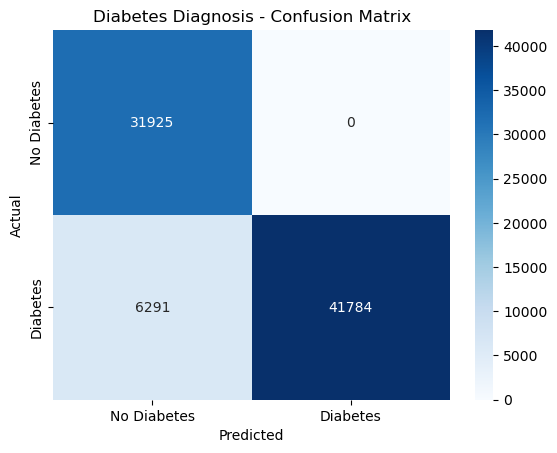

Accuracy: 0.9213625
Precision: 1.0
Recall: 0.8691419656786271
F1 Score: 0.9299903181651253


Test Set Metrics:


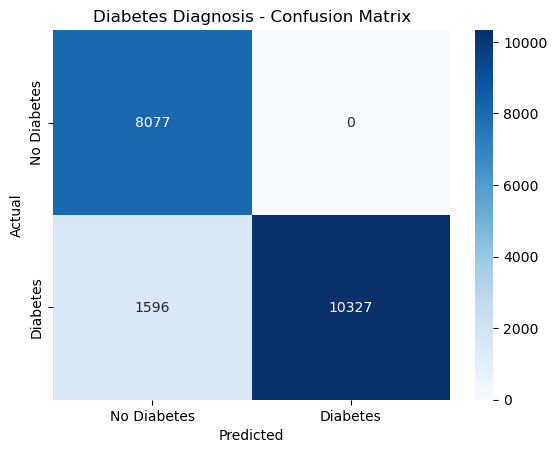

Accuracy: 0.9202
Precision: 1.0
Recall: 0.866141071877883
F1 Score: 0.9282696629213483


In [17]:
evaluate_metrics(y_train, y_train_pred, "Training Set Metrics:")

print("\n" + "="*75 + "\n")

evaluate_metrics(y_test, y_test_pred, "Test Set Metrics:")

It looks like we cannot get our f1 score above this value. Still, one more grid search is worth a try.

In [19]:
rf = RandomForestClassifier(random_state=2025)

parameters = {
    'n_estimators': [120, 150, 180],
    'max_features': [None],
    'bootstrap': [True],
    'max_samples': [None],
    'max_depth': [None, 12, 15, 17],
    'min_samples_leaf': [10],
    'min_samples_split': [10],
}

rf_search = GridSearchCV(
    estimator=rf,
    param_grid=parameters,
    scoring='f1',
    cv=5,
    n_jobs=-1,
    verbose=1
)

rf_search.fit(X_train, y_train)

n_estimators = rf_search.best_params_['n_estimators']
max_features = rf_search.best_params_['max_features']
bootstrap = rf_search.best_params_['bootstrap']
max_samples = rf_search.best_params_['max_samples']
max_depth = rf_search.best_params_['max_depth']
min_samples_leaf = rf_search.best_params_['min_samples_leaf']
min_samples_split = rf_search.best_params_['min_samples_split']

rf_search.best_params_

Fitting 5 folds for each of 12 candidates, totalling 60 fits


{'bootstrap': True,
 'max_depth': None,
 'max_features': None,
 'max_samples': None,
 'min_samples_leaf': 10,
 'min_samples_split': 10,
 'n_estimators': 120}

In [20]:
rf3 = RandomForestClassifier(
    n_estimators=n_estimators,
    max_features=max_features,
    bootstrap=bootstrap,
    max_samples=max_samples,
    max_depth=max_depth,
    min_samples_leaf=min_samples_leaf,
    min_samples_split=min_samples_split,
    random_state=2025,
    n_jobs=-1
)

rf3.fit(X_train, y_train)

,n_estimators,120
,criterion,'gini'
,max_depth,None
,min_samples_split,10
,min_samples_leaf,10
,min_weight_fraction_leaf,0.0
,max_features,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [21]:
y_train_pred = rf3.predict(X_train)
y_test_pred = rf3.predict(X_test)

Training Set Metrics:


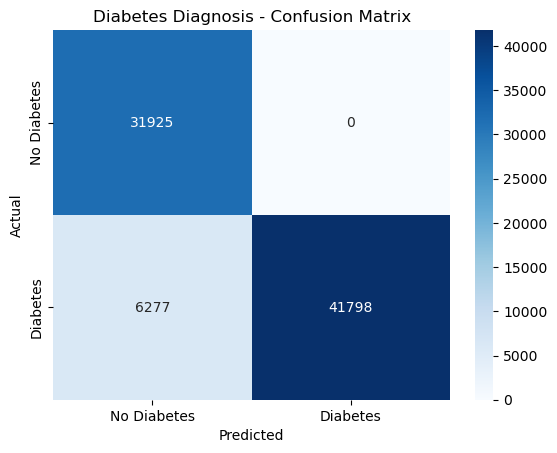

Accuracy: 0.9215375
Precision: 1.0
Recall: 0.8694331773270931
F1 Score: 0.9301569993212645


Test Set Metrics:


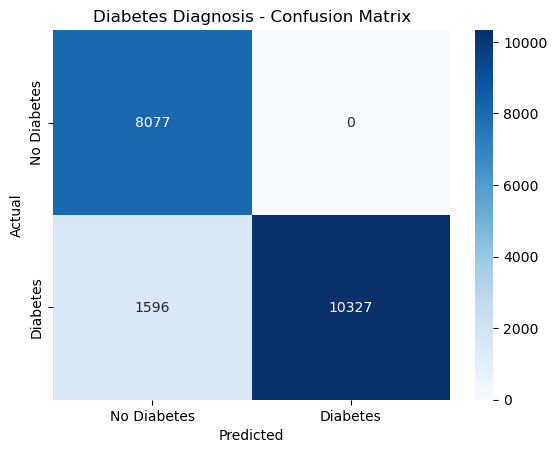

Accuracy: 0.9202
Precision: 1.0
Recall: 0.866141071877883
F1 Score: 0.9282696629213483


In [22]:
evaluate_metrics(y_train, y_train_pred, "Training Set Metrics:")

print("\n" + "="*75 + "\n")

evaluate_metrics(y_test, y_test_pred, "Test Set Metrics:")

Overfitting has been eliminated, but we still struggle with the same 1596 false negatives.

In [23]:
y_train_pred_proba = rf3.predict_proba(X_train)[:, 1]
y_test_pred_proba = rf3.predict_proba(X_test)[:, 1]

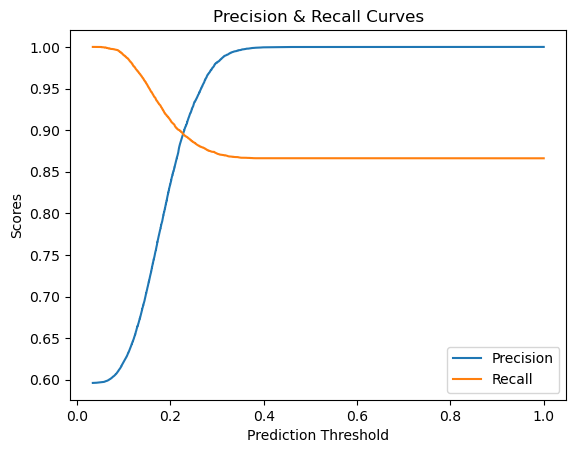

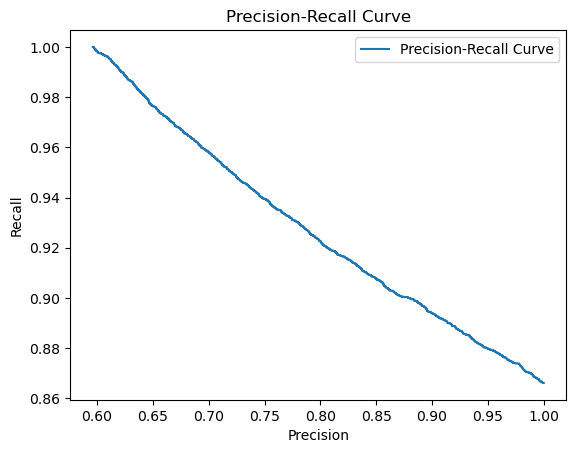

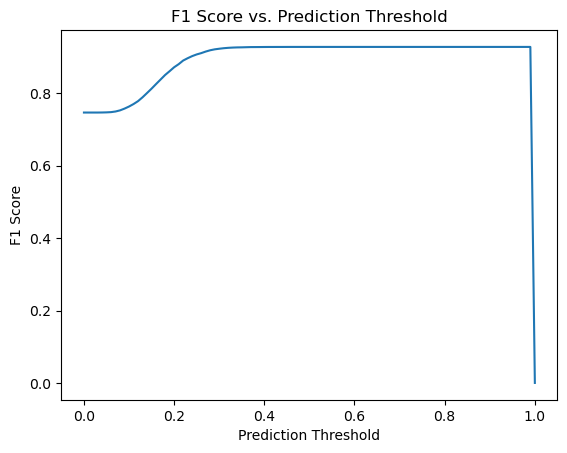

Optimal threshold: 0.46


In [24]:
thresh = optimize_threshold(y_test, y_test_pred_proba)
print(f"Optimal threshold: {thresh}")

In [25]:
preds_train = y_train_pred_proba >= thresh
preds_test = y_test_pred_proba >= thresh

Training Set Metrics with Optimized Threshold:


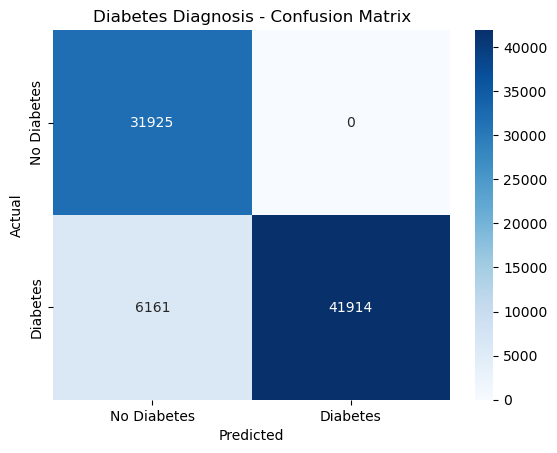

Accuracy: 0.9229875
Precision: 1.0
Recall: 0.8718460738429538
F1 Score: 0.9315360766315883


Test Set Metrics with Optimized Threshold:


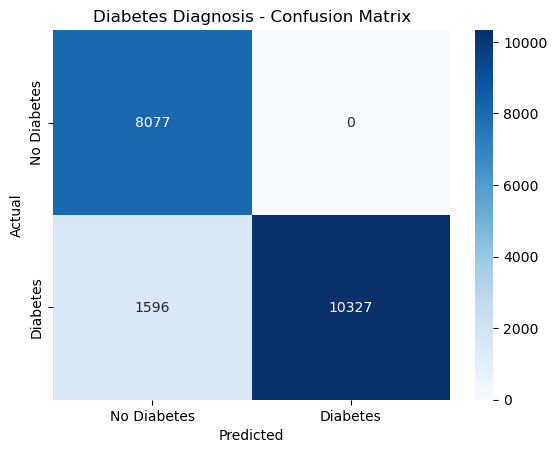

Accuracy: 0.9202
Precision: 1.0
Recall: 0.866141071877883
F1 Score: 0.9282696629213483


In [26]:
evaluate_metrics(y_train, preds_train, "Training Set Metrics with Optimized Threshold:")

print("\n" + "="*75 + "\n")

evaluate_metrics(y_test, preds_test, "Test Set Metrics with Optimized Threshold:")

It looks like these 1596 values cannot be properly classified.

Let us draw the roc curve.

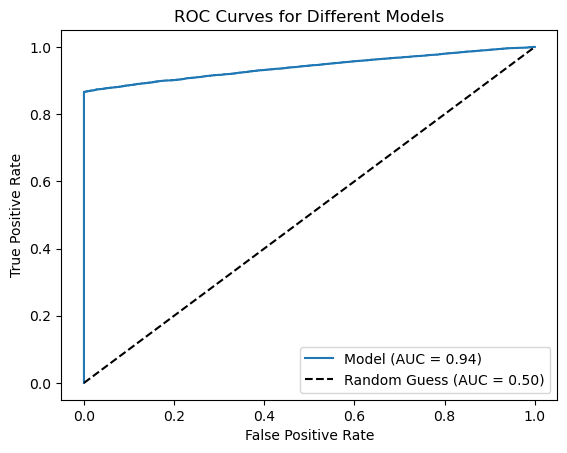

In [27]:
plot_roc_curve(y_test, y_test_pred_proba)

It is no different from the voting classifier model. We will now save the rf3 model.

In [28]:
joblib.dump(rf3, "../models/random_forest_model.joblib")

['../models/random_forest_model.joblib']